In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
train410M, val410M = torch.load("pythia-410M-deduped (Training, Validation) data: bs=8, nbatches=500, length=10).pt")
train1B, val1B   = torch.load("pythia-1B-deduped (Training, Validation) data: bs=8, nbatches=500, length=10).pt")
train1B4, val1B4 = torch.load("pythia-1.4B-deduped (Training, Validation) data: bs=8, nbatches=500, length=10).pt")
train2B8, val2B8 = torch.load("pythia-2.8B-deduped (Training, Validation) data: bs=8, nbatches=500, length=10).pt")
train6B9, val6B9 = torch.load("pythia-6.9B-deduped (Training, Validation) data: bs=8, nbatches=500, length=10).pt")

In [10]:
train2B8.mean()

tensor(-0.1701)

In [12]:
val2B8.nanmean()

tensor(-0.2189)

In [88]:
torch.load("pythia-410M-deduped (Training, Validation) data: bs=8, nbatches=500, length=10).pt")

tensor([[-1.0109e-05, -5.3930e-05, -1.4591e-05,  ..., -3.3379e-06,
         -2.8477e-04, -1.5363e-03],
        [-2.2469e-03, -5.6839e-05, -4.5776e-05,  ..., -4.3106e-05,
         -4.1971e-04, -1.7567e-04]])

In [82]:
def compute_fpr_tpr_thresholds(valuestraining, valuesvalidation, st, end):
    not_nan = torch.logical_not(torch.logical_or( torch.isnan(valuestraining),torch.isnan(valuesvalidation)))
    valuestraining = valuestraining[not_nan]
    valuesvalidation = valuesvalidation[not_nan]

    y_scores =  torch.cat((valuestraining, valuesvalidation))
    y_scores = y_scores-st
    y_scores = y_scores/end
    y_true   = [1 for _ in range(len(valuestraining))] + [0 for _ in range(len(valuesvalidation))]

    return roc_curve(y_true,y_scores)

In [85]:
compute_fpr_tpr_thresholds(train410M, val410M, st, end)

ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [83]:
from sklearn.metrics import roc_curve, auc
everything = torch.cat((train410M, train1B, train1B4, train2B8, train6B9, val410M, val1B, val1B4, val2B8, val6B9))
st = min(everything)
end = max(everything-min(everything))
print(st,end)


fpr410M, tpr410M, thresholds410M = compute_fpr_tpr_thresholds(train410M, val410M, st, end)
fpr1B,  tpr1B, thresholds1B = compute_fpr_tpr_thresholds(train1B, val1B, st, end)
fpr1B4, tpr1B4, thresholds1B4 = compute_fpr_tpr_thresholds(train1B4, val1B4, st, end)
fpr2B8, tpr2B8, thresholds2B8 = compute_fpr_tpr_thresholds(train2B8, val2B8, st, end)
fpr6B9, tpr6B9, thresholds6B9 = compute_fpr_tpr_thresholds(train6B9, val6B9, st, end)


# Calculate the area under the ROC curve (AUC)
roc_auc410M = auc(fpr410M, tpr410M)
roc_auc1B = auc(fpr1B, tpr1B)
roc_auc1B4 = auc(fpr1B4, tpr1B4)
roc_auc2B8 = auc(fpr2B8, tpr2B8)
roc_auc6B9 = auc(fpr6B9, tpr6B9)

# Plot the ROC curve
plt.plot(fpr410M, tpr410M, color='darkorange', label='410M param ROC curve (area = %0.2f)' % roc_auc410M)
plt.plot(fpr1B, tpr1B, color='darkred', label='1B param ROC curve (area = %0.2f)' % roc_auc1B)
plt.plot(fpr1B4, tpr1B4, color='darkgreen', label='1.4B param ROC curve (area = %0.2f)' % roc_auc1B4)
plt.plot(fpr2B8, tpr2B8, color='darkorange', label='2.8B param ROC curve (area = %0.2f)' % roc_auc2B8)
plt.plot(fpr6B9, tpr6B9, color='lightblue', label='6.9B param ROC curve (area = %0.2f)' % roc_auc6B9)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc all models.png")

tensor(nan) tensor(nan)


ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [60]:
def compute_how_many(c, training, validation):
    trainlength = len(training[training>=c])
    vallength   = len(validation[validation>= c ])
    return (vallength+trainlength)

def compute_threshold(c, training, validation):
    trainlength = len(training[training>=c])
    vallength   = len(validation[validation>= c ])
    return trainlength/(vallength+trainlength)
def plot_fract_in_training_wrt_model_size(threshold):
    model_sizes = [410, 1000, 1400, 2800, 6900] # in millions

    # Example performance metric values for each model size
    # Replace with your own values
    performance = [compute_threshold(threshold, train410M, val410M), 
                   compute_threshold(threshold, train1B, val1B), 
                   compute_threshold(threshold, train1B4, val1B4), 
                   compute_threshold(threshold, train2B8, val2B8),
                   compute_threshold(threshold, train6B9, val6B9),
                  ]

    plt.title("Threshold attack success vs Model Size")
    plt.xlabel("Model Size (Millions of Parameters)")
    plt.ylabel("# in training set/(# in training and val sets)")
    plt.plot(model_sizes, performance, marker='o')



In [69]:
thresholds = np.arange(-0.05,-0.00001,0.00001)
# length410M = [compute_how_many(t, train410M, val410M) for t in thresholds]
# prob410M = [compute_threshold(t, train410M, val410M) for t in thresholds]

length1B = [compute_how_many(t, train1B, val1B) for t in thresholds]
prob1B = [compute_threshold(t, train1B, val1B) for t in thresholds]

length1B4 = [compute_how_many(t, train1B4, val1B4) for t in thresholds]
prob1B4 = [compute_threshold(t, train1B4, val1B4) for t in thresholds]


length2B8 = [compute_how_many(t, train2B8, val2B8) for t in thresholds]
prob2B8 = [compute_threshold(t, train2B8, val2B8) for t in thresholds]

length6B9 = [compute_how_many(t, train6B9, val6B9) for t in thresholds]
prob6B9 = [compute_threshold(t, train6B9, val6B9) for t in thresholds]

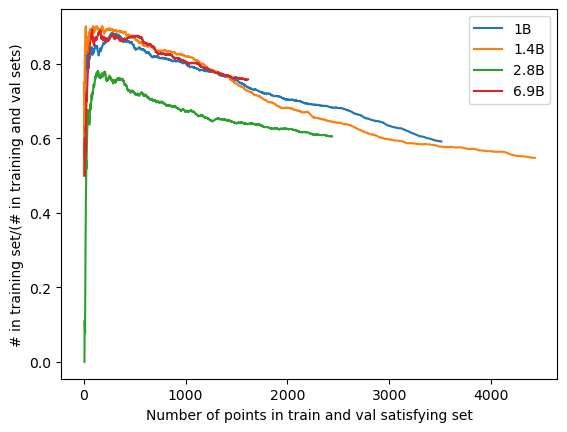

In [73]:
# plt.plot(length410M, prob410M, label = "410m")
plt.plot(length1B, prob1B, label = "1B")
plt.plot(length1B4, prob1B4, label = "1.4B")
plt.plot(length2B8, prob2B8, label = "2.8B")
plt.plot(length6B9, prob6B9, label = "6.9B")

plt.xlabel("Number of points in train and val satisfying set")
plt.ylabel("# in training set/(# in training and val sets)")

plt.legend()
plt.show()

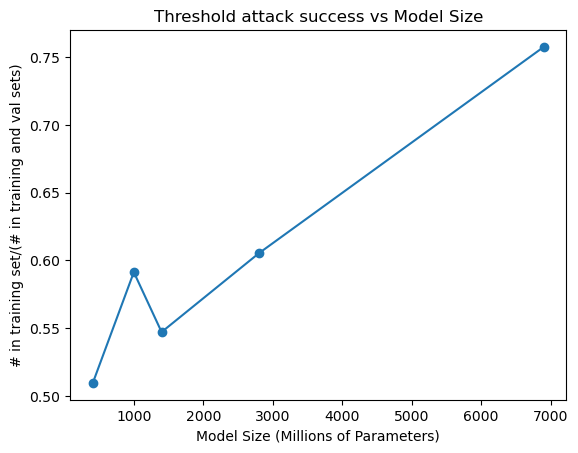

In [74]:
plot_fract_in_training_wrt_model_size(-0.05)